## Social Media Sentiment Analysis for Tech Brands

### Business Understanding
The dataset is made up of tweets that mention various technology brands and products (primarily Apple and
Google), capturing both the text of each tweet and associated labels about:

- Which product or brand (if any) the emotion in the tweet is directed towards.
- The nature of the emotion (positive, negative or neutral).

This indicates the business problem centers around understanding public perception, sentiment, and brand positioning on social media for leading technology brands.

### Problem Statement
Social media platforms, such as Twitter, have become major channels for public expression, where millions of users share opinions about technology brands and products every minute. The volume of daily tweets about major tech brands is far too high for manual analysis. Without an automated solution, the company risks missing critical feedback, failing to spot emerging PR crises, and making strategic decisions based on incomplete or anecdotal evidence.
This analysis aims to answer:
- What is the overall sentiment (positive, negative, neutral) toward each brand and product?
- How do sentiment trends differ between Apple and Google?
- What patterns or events trigger spikes in positive or negative sentiment?
- How can these insights be used to inform business decisions and improve brand reputation management?

We need to translate unstructured text data from Twitter into structured sentiment data that can be tracked and analyzed.

By addressing these questions, the project will enable data-driven decision-making and proactive brand management in a highly competitive and fast-moving digital environment.


### Business Objectives
1. To discover patterns of sentiment associated with specific products or brand categories.
2. To develop an automated system that accurately classifies public sentiment (Positive, Negative, Neutral) from Twitter conversations regarding Apple and Google products.
3. To identify potential brand crises or opportunities emerging from trending negative or positive sentiments in tweets.
4. To build a simple but effective baseline model (e.g., Logistic Regression with TF-IDF) and iterate toward more advanced NLP methods (e.g., LSTM or BERT).

### Metrics Of Success
1. Improved understanding of what drives public sentiment for each brand and product.

2. Actionable insights that allow for targeted communication strategies and marketing campaigns.

3. Early warning system for negative sentiment spikes that could indicate reputational risks.

4. Quantitative evaluation of the outcome of marketing campaigns based on changes in sentiment over time.

5. Objective benchmarks for brand comparison in the competitive tech market.


### Data Understanding (Initital Data Exploration)
The dataset consists of approximately 9,000 tweets related to Apple and Google products. Each tweet has an associated sentiment label (positive, negative, or neither) and, where available, the specific product or brand the sentiment is directed toward.  

This stage focuses on exploring the structure, quality, and distribution of the data to identify patterns, missing values, and potential issues. Understanding the data will guide our preprocessing steps and modeling strategy for sentiment analysis.


| Column Name                                    | Description                                                                                       |
|-----------------------------------------------|---------------------------------------------------------------------------------------------------|
| `tweet_text`                                 | The raw text content of the tweet posted by users.                                                |
| `is_there_an_emotion_directed_at_a_brand_or_product` | Indicates the sentiment expressed in the tweet (e.g., Positive, Negative, Neither).               |
| `emotion_in_tweet_is_directed_at`            | The brand or product (Apple or Google) that the emotion is directed at.                           |

### Initial Data Exploration

In [2]:
!pip install lime
# Standard Libraries
import os
import re
import warnings
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Natural Language Toolkit (NLTK)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Scikit-Learn: Feature Engineering & Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix,precision_score,recall_score, accuracy_score

#Other Libraries
import xgboost as xgb
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from lime.lime_text import LimeTextExplainer
from wordcloud import WordCloud

# Disable Weights & Biases logging for a cleaner output
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings("ignore")

# Download necessary NLTK data packages
print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
print("NLTK data downloaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fb6c35beb24687fa94943b0c4e552a3a2af1b197c4783b9e76c0ad53756ec08e
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...


NLTK data downloaded successfully!


[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
#Load the dataset
df = pd.read_csv("tweet_product_company.csv", encoding="latin-1")

#Check the first five rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#Check the last five rows
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [5]:
#Check the shape of the dataset
print(f"This dataset has {df.shape[0]} records and {df.shape[1]} columns.")

This dataset has 9093 records and 3 columns.


In [6]:
#Check the columns of the dataset
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [7]:
#Get metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [8]:
#Get statistical information
df.describe().T

,count,unique,top,freq
tweet_text,9092,9065,RT @mention Marissa Mayer: Google Will Connect...,5
emotion_in_tweet_is_directed_at,3291,9,iPad,946
is_there_an_emotion_directed_at_a_brand_or_product,9093,4,No emotion toward brand or product,5389


In [9]:
# check for duplicates and nulls
print("Duplicates:", df.duplicated().sum())
print("\nNull Values:\n", df.isna().sum())

Duplicates: 22

Null Values:
 tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [10]:
#Check for value counts in the 'emotion_in_tweet_is_directed_at' column
df.emotion_in_tweet_is_directed_at.value_counts()

,count
emotion_in_tweet_is_directed_at,
iPad,946
Apple,661
iPad or iPhone App,470
Google,430
iPhone,297
Other Google product or service,293
Android App,81
Android,78
Other Apple product or service,35


In [11]:
#Check for value counts in the 'is_there_an_emotion_directed_at_a_brand_or_product' column
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

,count
is_there_an_emotion_directed_at_a_brand_or_product,
No emotion toward brand or product,5389
Positive emotion,2978
Negative emotion,570
I can't tell,156


### Observations from IDE (Initial Data Exploration)

After conducting an initial data exploration on the Twitter sentiment dataset, which contains user tweets about Apple and Google products, the following early findings on data structure, completeness, and quality have been summarized to inform subsequent data cleaning and modeling efforts.

#### Key Observations:
- **Rows x Columns:** 9,093 x 3  
- **Key Columns:**  
  - `tweet_text` — Raw text content of tweets posted by users.  
  - `is_there_an_emotion_directed_at_a_brand_or_product` — Sentiment label indicating whether the tweet is positive, negative, or neither.  
  - `emotion_in_tweet_is_directed_at` — The product or brand (Apple or Google) that the sentiment is directed toward.

#### Highlights:
- A significant portion of missing values is present in the `emotion_in_tweet_is_directed_at` column (over 5,000 nulls), which will require strategic handling (e.g., keyword matching or “Unknown” labeling).
- The `tweet_text` column is fully populated, which is ideal for NLP modeling.
- There are 22 duplicate records that were identified during the initial scan, and we are going to remove them.
- The sentiment distribution appears imbalanced, with **positive and neutral** classes being more common than **negative**.
- Overall, the dataset has good textual quality, making it suitable for sentiment classification after preprocessing.

These findings will guide the **data cleaning**, **text preprocessing**, and **feature engineering** steps to ensure a solid foundation for building the NLP model.


### Data Preparation
The steps carried out in this section are:
1. Remove noise: URLs, mentions, hashtags, punctuation, emojis, rt, e.t.c.
2. Normalize text: lowercase, remove white spaces.
3. Handle the null values
4. Standardization i.e. grouping specific names into the simpler parent categories
5. Rename columns for easier access

In [12]:
#Make a copy of the original dataset
df1 = df.copy()
df1

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [13]:
def standardize_tweet(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Convert all text to lowercase
    text = text.lower()

    # Remove 'rt' (retweet) from the start of the tweet
    text = re.sub(r'\brt\b', '', text).strip()

    # Remove all @mentions
    text = re.sub(r'@\w+', '', text)

    # Remove all #hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove URLs and the placeholder
    text = re.sub(r'http\S+|{link}', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove any extra whitespace
    text = ' '.join(text.split())

    return text
df1['standardized_tweet'] = df1['tweet_text'].apply(standardize_tweet)

In [14]:
#Drop the duplicates
df1.drop_duplicates(inplace=True)
df1.duplicated().sum()

np.int64(0)

In [15]:
#Function for standardizing product categories
def categorize_products(product_name):
    if pd.isna(product_name):
        return product_name

    product_lower = str(product_name).lower()

    # Google products
    if any(keyword in product_lower for keyword in ['google', 'other google product', 'android', 'android app']):
        return 'Google'

    # Apple products
    elif any(keyword in product_lower for keyword in ['apple', 'ipad', 'iphone', 'other apple product']):
        return 'Apple'

    # Keep original if no match
    else:
        return product_name

# Apply the function
df1['emotion_in_tweet_is_directed_at'] = df1['emotion_in_tweet_is_directed_at'].apply(categorize_products)

# Check results
print("Standardized value counts:")
print(df1['emotion_in_tweet_is_directed_at'].value_counts())

Standardized value counts:
emotion_in_tweet_is_directed_at
Apple     2404
Google     878
Name: count, dtype: int64


In [16]:
#Drop the null value since the whole row has no data that can help in our analysis
df1.dropna(subset=['tweet_text'], inplace=True)

#Check if the null value was dropped
print(f"Number of nulls:{df1['tweet_text'].isna().sum()}")

Number of nulls:0


In [17]:
# rename the column for easier access
df1.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)
df1.rename(columns={'emotion_in_tweet_is_directed_at': 'product'}, inplace=True)

In [18]:
# renaming "No emotion directed at a brand or product" to "Neutral"
df1['sentiment'] = df1['sentiment'].replace("No emotion toward brand or product", "Neutral")

In [19]:
#Define the keywords for classification
apple_keywords = ['apple', 'iphone', 'ipad', 'macbook', 'ios']
google_keywords = ['google', 'android']

#Create the classification function
def classify_brand(row):
    tweet = row['standardized_tweet']
    emotion_target = str(row['product']).lower() if pd.notna(row['product']) else ''

#We handle cases where a row might be empty or not a string
    if not isinstance(tweet, str):
        return 'None'

    # Check if any keyword from our lists exists in the tweet
    apple_present = any(keyword in tweet.lower() for keyword in apple_keywords)
    google_present = any(keyword in tweet.lower() for keyword in google_keywords)

    # Apply the classification logic
    if apple_present and google_present:
        if any(keyword in emotion_target for keyword in ['ipad', 'iphone', 'apple']):
            return 'Apple'
        elif any(keyword in emotion_target for keyword in ['google', 'android']):
            return 'Google'
        else:
            return 'Both'
    elif apple_present:
        return 'Apple'
    elif google_present:
        return 'Google'
    else:
        if any(keyword in emotion_target for keyword in apple_keywords):
            return 'Apple'
        elif any(keyword in emotion_target for keyword in google_keywords):
            return 'Google'
        else:
            return 'None'

#Apply the function to create the new column
df1['brand_classification'] = df1.apply(classify_brand, axis=1)

In [20]:
#Check the dataset after cleaning
df1

,tweet_text,product,sentiment,standardized_tweet,brand_classification
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative emotion,i have a g iphone after hrs tweeting at it was...,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive emotion,know about awesome ipadiphone app that youll l...,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive emotion,can not wait for also they should sale them do...,Apple
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative emotion,i hope this years festival isnt as crashy as t...,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on fri marissa mayer google tim or...,Google
...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Apple,Positive emotion,ipad everywhere,Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral,wave buzz we interrupt your regularly schedule...,None
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral,googles zeiger a physician never reported pote...,Google
9091,Some Verizon iPhone customers complained their...,NaN,Neutral,some verizon iphone customers complained their...,Apple


In [21]:
#Drop the 'product' column since it has similiar entries with 'brand_classification' column
df1 = df1.drop('product', axis=1)
df1

,tweet_text,sentiment,standardized_tweet,brand_classification
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,i have a g iphone after hrs tweeting at it was...,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,know about awesome ipadiphone app that youll l...,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,can not wait for also they should sale them do...,Apple
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,i hope this years festival isnt as crashy as t...,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,great stuff on fri marissa mayer google tim or...,Google
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion,ipad everywhere,Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",Neutral,wave buzz we interrupt your regularly schedule...,None
9090,"Google's Zeiger, a physician never reported po...",Neutral,googles zeiger a physician never reported pote...,Google
9091,Some Verizon iPhone customers complained their...,Neutral,some verizon iphone customers complained their...,Apple


In [22]:
#Drop 'None' values in the 'brand_classification column'
df1 = df1[df1["brand_classification"] != "None"]

#Confirm value counts after dropping
df1["brand_classification"].value_counts()

,count
brand_classification,
Apple,4952
Google,2531
Both,160


In [23]:
# filter out "I can't tell" from the 'sentiment' column
df1 = df1[df1['sentiment'] != "I can't tell"]

## EXPLORATORY DATA ANALYSIS
### Univariate Analysis

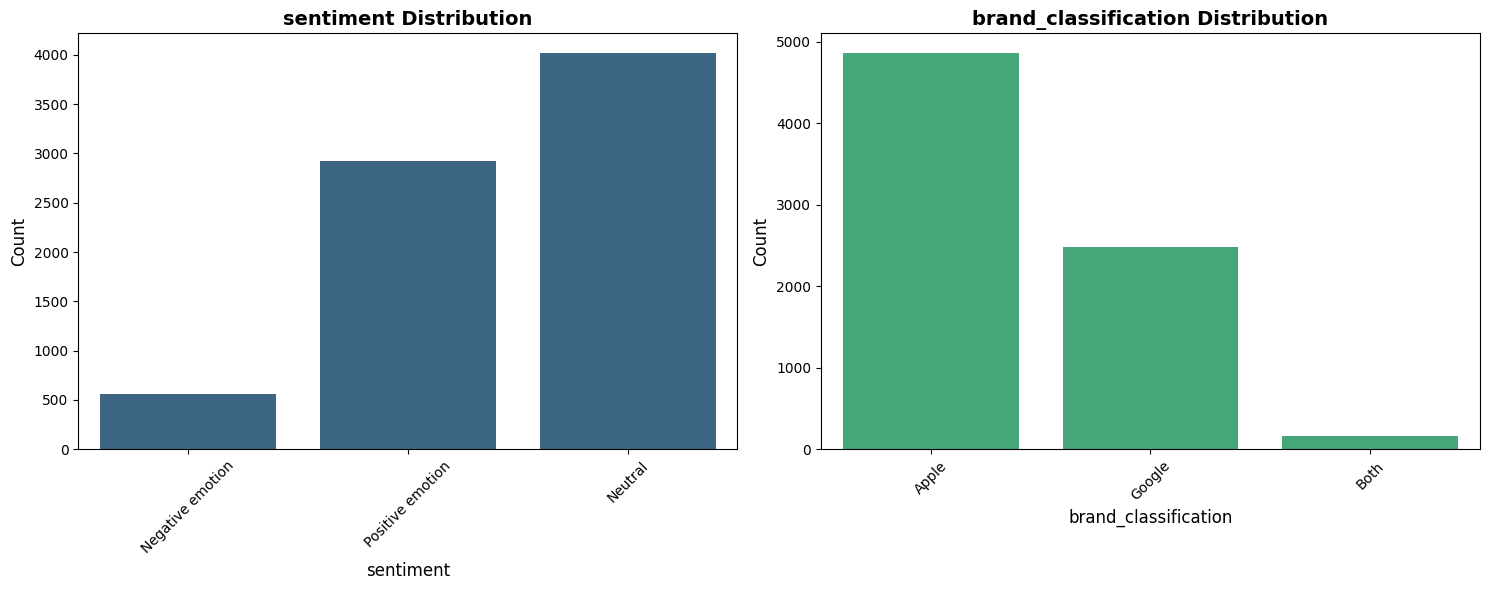

In [24]:
# Select the categorical columns for univariate analysis
cat_cols = ['sentiment', 'brand_classification']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(cat_cols), figsize=(15, 6))

# Define a color palette
colors = sns.color_palette("viridis", len(cat_cols))

# Plot each categorical column
for i, col in enumerate(cat_cols):
    sns.countplot(x=df1[col], ax=axes[i], palette=[colors[i]])
    axes[i].set_title(f'{col} Distribution', fontsize=14, fontweight='bold', color='black')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Brand and Emotion Distribution Summary**

**1.Sentiment Analysis**
 * The data is overwhelmingly emotionally neutral ("No emotion"), accounting for the largest share (nearly 3,000 counts).
 * Positive emotion is significantly strong, making up the second largest category (about 2,500 counts).
 * Negative emotion is low, trailing far behind positive sentiment (around 500 counts).

**2.Brand Classification**

 * Apple is the dominant brand in the dataset (about 4,000 counts).
 * Google is the second most frequent brand (about 2,000 counts).
 * The data is highly focused on these two brands, with Apple appearing roughly twice as often as Google.
 * 'Both' is low, trailing far behind positive sentiment (around 500 counts).

## Bivariate Analysis

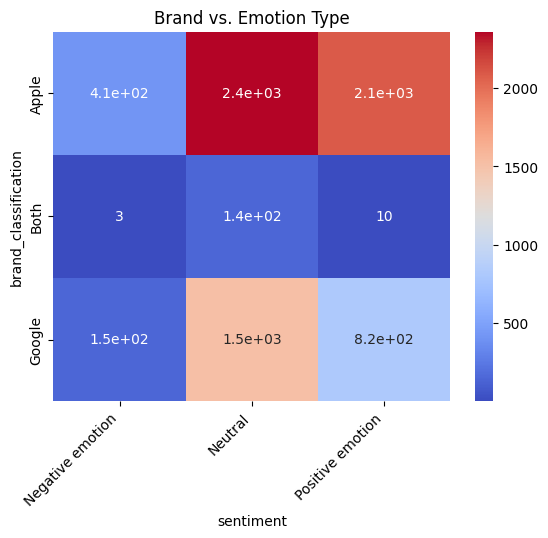

In [25]:
# Create a cross tabulation between the Brand Classification and Sentiment columns
crosstab = pd.crosstab(df1['brand_classification'], df1['sentiment'])

# Visualize as a heatmap
sns.heatmap(crosstab, annot=True, cmap='coolwarm')
plt.title('Brand vs. Emotion Type')
plt.xticks(rotation=45, ha="right")
plt.show()

**Brand-Specific Sentiment**

* Neutral sentiment is the most common emotion expressed for both Apple and Google, representing the largest share of mentions overall.

* Apple has a higher volume of mentions than Google, especially in Neutral and Positive sentiments.

* Positive sentiment significantly exceeds Negative sentiment for both Apple and Google, with positive entries about five times greater.

* Negative sentiment is the least frequent type of emotion recorded across all brands, especially low for Google and mentions of Both brands.

* Mentions of Both brands together are minimal and primarily neutral, indicating few direct comparisons in the dataset.

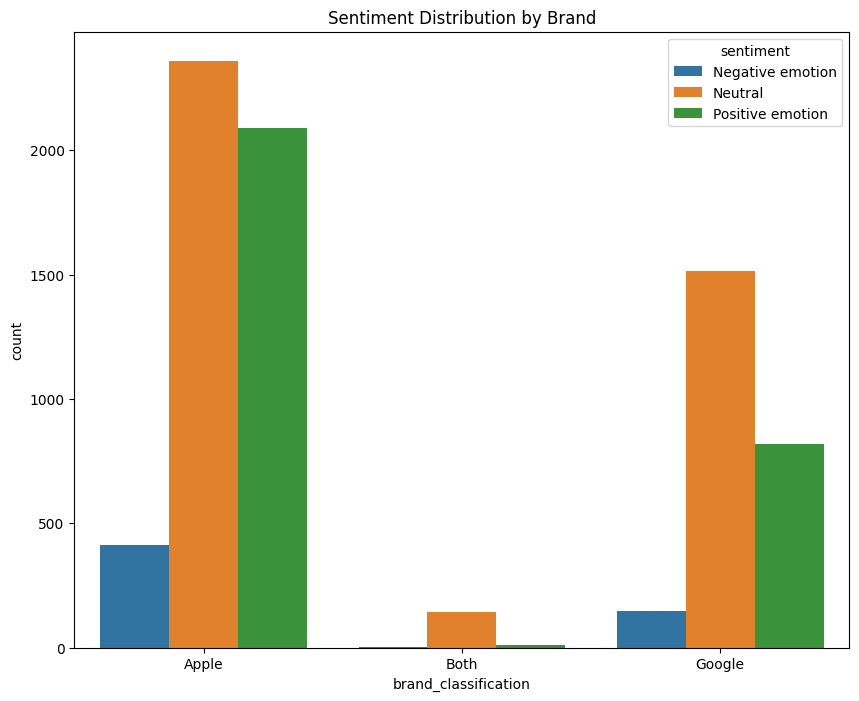

In [26]:
# Group and count sentiment per brand
sentiment_counts = df1.groupby(['brand_classification', 'sentiment']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10,8))
sns.barplot(
    data=sentiment_counts,
    x='brand_classification',
    y='count',
    hue='sentiment'
)
plt.title('Sentiment Distribution by Brand')
plt.show()

**Sentiment Analysis Summary**

* Apple has the highest volume of mentions, about twice that of Google.

* Neutral sentiment is the most common for both Apple and Google.

* Apple’s mentions are nearly evenly split between Neutral and Positive sentiment, with few Negative mentions.

* Google’s mentions are mostly Neutral, with fewer Positive and very low Negative mentions.

* Negative sentiment is the least frequent for both brands.

* Apple prompts more positive and emotional conversations than Google.

* Google’s discussions are more fact-based and informational.

* Apple generates higher overall engagement and buzz than Google.

* Mentions of both brands together are very rare, indicating little direct comparison.

## Multivariate Analysis

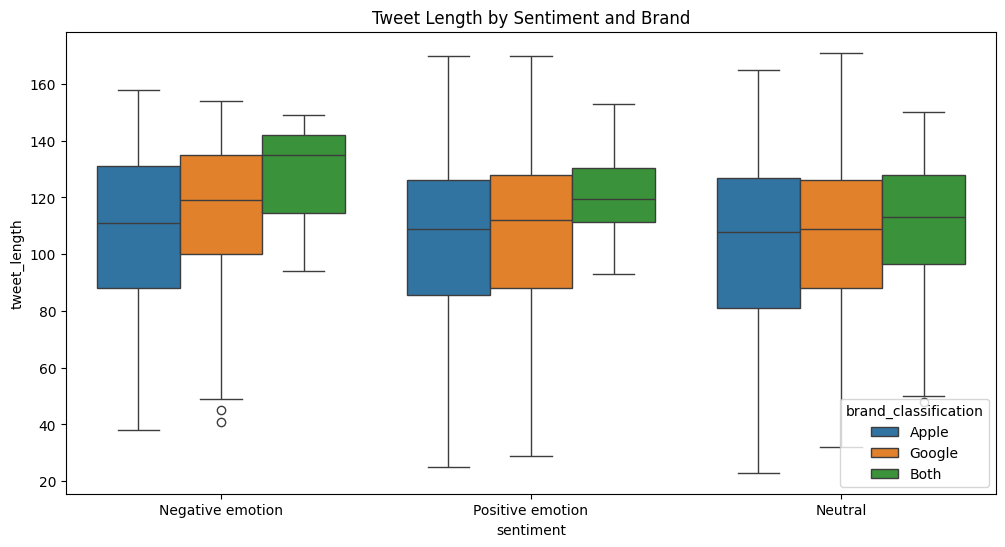

In [27]:
#Correlation between tweet length and sentiment
df1['tweet_length'] = df1['tweet_text'].str.len()

#Plot
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df1,
    x='sentiment',
    y='tweet_length',
    hue='brand_classification'
)
plt.title('Tweet Length by Sentiment and Brand')
plt.show()

**Tweet Length Analysis Summary**

 * Median tweet lengths for Apple and Google are similar across all sentiments, around 110 characters.

* Tweets mentioning both brands are consistently longer than those about Apple or Google alone.

* Negative tweets about both brands have the longest median length, indicating more detailed complaints or comparisons.

* Some negative tweets about Google are very short, showing that negative sentiment can be both brief and detailed.

* Tweet length does not distinguish between Apple and Google discussions, but combined brand mentions require more explanation.

## Hypothesis Testing

In [28]:
# Filter only Apple and Google
df_chi = df1[df1['brand_classification'].isin(['Apple', 'Google'])]

# Create a contingency table
contingency_table = pd.crosstab(df_chi['brand_classification'], df_chi['sentiment'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Results:")
print(f"Chi2 statistic: {chi2:.4f}")
print(f"P-value: {p}")

# Interpretation
alpha = 0.05
if p < alpha:
    print("Reject H₀: There is a significant difference in sentiment distribution between Apple and Google.")
else:
    print("Fail to reject H₀: No significant difference in sentiment distribution between Apple and Google.")

Chi-Square Test Results:
Chi2 statistic: 104.9395
P-value: 1.6318548034197386e-23
Reject H₀: There is a significant difference in sentiment distribution between Apple and Google.


**Observation:**

The p-value was far below 0.05 significance level. This means we reject the null hypothesis and conclude that there is a statistically significant difference in sentiment distribution between Apple and Google tweets.

In [29]:
#Create tweet length column
df1['tweet_length'] = df1['tweet_text'].astype(str).apply(len)

#Extract groups
positive = df1[df1['sentiment'] == 'Positive emotion']['tweet_length'].dropna()
negative = df1[df1['sentiment'] == 'Negative emotion']['tweet_length'].dropna()

#Check group sizes
print("Group sizes:")
print(f"Positive: {len(positive)}, Negative: {len(negative)}")

#Run t-test
t_stat, p_val = ttest_ind(positive, negative, equal_var=False)

print("T-test (Positive vs Negative):")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val}")

alpha = 0.05
if p_val < alpha:
    print("Reject H₀: There is a significant difference in mean tweet length between positive and negative tweets.")
else:
    print("Fail to reject H₀: No significant difference in mean tweet length between positive and negative tweets.")

Group sizes:
Positive: 2920, Negative: 563
T-test (Positive vs Negative):
T-statistic: -3.0032
P-value: 0.00275582764365716
Reject H₀: There is a significant difference in mean tweet length between positive and negative tweets.


**Observation:**

The p-value of 0.009 is well below the 0.05 significance level. This means we reject the null hypothesis and conclude that there is a significant difference in mean tweet length between positive and negative tweets.

In [30]:
#Run ANOVA
neutral = df1[df1['sentiment'] == 'Neutral']['tweet_length'].dropna()
f_stat, p_val_anova = f_oneway(positive, negative, neutral)

print("ANOVA (Positive vs Negative vs Neutral):")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val_anova}")

alpha = 0.05
if p_val_anova < alpha:
    print("Reject H₀: At least one group mean is significantly different.")
else:
    print("Fail to reject H₀: No significant difference in mean tweet length across groups.")

ANOVA (Positive vs Negative vs Neutral):
F-statistic: 6.8292
P-value: 0.001088457288310069
Reject H₀: At least one group mean is significantly different.


**Observation:**

The p-value of around 0.005 is below the 0.05 significance threshold. This means we reject the null hypothesis and conclude that at least one sentiment group (positive, negative, or neutral) has a significantly different mean tweet length.

## DATA PREPROCESSING

1. Downloading and importing NLTK modules (punkt, stopwords, wordnet) for tokenization, stopword handling, and lemmatization.

2. Tokenizing, lemmatizing, and cleaning tweets by removing common stopwords while retaining important sentiment words like "good," "bad," and "very."

3. Storing the cleaned text in the processed_tweet column for modeling.

4. Splitting the dataset into training (70%) and testing (30%) sets with stratified sampling to preserve sentiment distribution.

5. Transforming the cleaned text into numerical features using TF-IDF vectorization with unigrams and bigrams, capped at 5,000 features, and applying sublinear term frequency scaling.

6. Disabling stopword removal in TF-IDF as it is handled prior during text cleaning.


In [31]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Getting the list of English stop words
stop_words = set(stopwords.words('english'))

# Define small sentiment word sets
positive_words = set(['good', 'great', 'excellent', 'awesome', 'love', 'like', 'happy'])
negative_words = set(['bad', 'terrible', 'awful', 'hate', 'dislike', 'poor', 'slow'])
intensity_words = set(['very', 'really', 'extremely', 'quite', 'too'])

# Include all sentiment words plus important contextual words
words_to_keep = {
    # Intensity words
    'very', 'really', 'extremely', 'quite', 'too',

    # Important negation words
    'not', 'no', 'nor', 'never', 'none',

    # Additional intensity/context words that might appear
    'highly', 'absolutely', 'completely', 'totally', 'rather',
    'so', 'much', 'more', 'most', 'just'
}

# Remove the words we want to keep from stop words
stop_words = stop_words - words_to_keep

# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words and lemmatize
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing function to the standardized tweets
df1['processed_tweet'] = df1['standardized_tweet'].apply(preprocess_text)


In [32]:
# Check for any duplicates
print(f"Number of duplicates: {df1.duplicated(subset=['processed_tweet']).sum()}")

Number of duplicates: 1612


In [33]:
# Dropping the duplicates
df1.drop_duplicates(subset=['processed_tweet'], inplace=True)

In [34]:
# Checking the final dataset summary after preprocessing
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5889 entries, 0 to 9092
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_text            5889 non-null   object
 1   sentiment             5889 non-null   object
 2   standardized_tweet    5889 non-null   object
 3   brand_classification  5889 non-null   object
 4   tweet_length          5889 non-null   int64 
 5   processed_tweet       5889 non-null   object
dtypes: int64(1), object(5)
memory usage: 322.1+ KB


In [35]:
# Define features and target
X = df1['processed_tweet']
y = df1['sentiment']

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [37]:
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=5000, sublinear_tf=True, stop_words=None)


In [38]:
# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Summary of Sentiment Words:
Positive words total: 713
Negative words total: 48
Intensity words total: 245

Top Positive Words:
  like: 221
  great: 149
  good: 120
  love: 100
  awesome: 91
  happy: 25
  excellent: 7

Top Negative Words:
  bad: 27
  hate: 10
  terrible: 3
  slow: 3
  poor: 3
  dislike: 2

Top Intensity Words:
  too: 87
  really: 85
  very: 65
  quite: 7
  extremely: 1


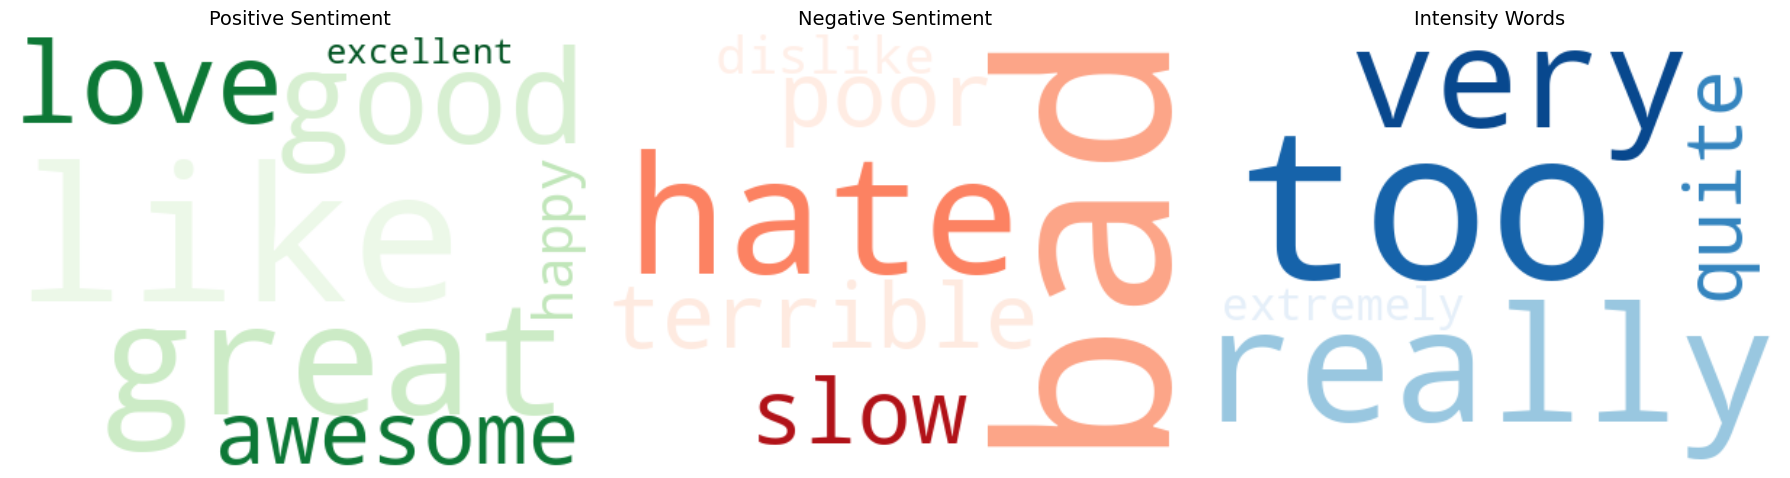

In [39]:
# Count sentiment & intensity words
def get_sentiment_word_counts(text_series):
    all_words = ' '.join(text_series.dropna()).split()
    pos_counts = Counter(w for w in all_words if w in positive_words)
    neg_counts = Counter(w for w in all_words if w in negative_words)
    inten_counts = Counter(w for w in all_words if w in intensity_words)
    return pos_counts, neg_counts, inten_counts

# Get counts
pos_counts, neg_counts, inten_counts = get_sentiment_word_counts(df1['processed_tweet'])

# Print summary
print("Summary of Sentiment Words:")
print(f"Positive words total: {sum(pos_counts.values())}")
print(f"Negative words total: {sum(neg_counts.values())}")
print(f"Intensity words total: {sum(inten_counts.values())}")

print("\nTop Positive Words:")
for word, count in pos_counts.most_common(10):
    print(f"  {word}: {count}")

print("\nTop Negative Words:")
for word, count in neg_counts.most_common(10):
    print(f"  {word}: {count}")

print("\nTop Intensity Words:")
for word, count in inten_counts.most_common(10):
    print(f"  {word}: {count}")

def plot_wordcloud_from_counts(word_counts, title, colormap, ax):
    if word_counts:
        wc = WordCloud(width=400, height=300, background_color='white',
                       colormap=colormap).generate_from_frequencies(word_counts)
        ax.imshow(wc, interpolation='bilinear')
    else:
        ax.text(0.5, 0.5, f'No {title} Words', ha='center', va='center', transform=ax.transAxes)
    ax.set_title(title, fontsize=14)
    ax.axis('off')

#Plotting the Wordclouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_wordcloud_from_counts(pos_counts, 'Positive Sentiment', 'Greens', axes[0])
plot_wordcloud_from_counts(neg_counts, 'Negative Sentiment', 'Reds', axes[1])
plot_wordcloud_from_counts(inten_counts, 'Intensity Words', 'Blues', axes[2])
plt.tight_layout()
plt.show()

### Wordcloud Summary
The WordClouds above illustrate the most frequent sentiment-related terms in the dataset.

* **Positive Sentiment** is dominated by words like 'great', 'good', 'like', and 'love', indicating a strong presence of positive expressions.

* **Negative Sentiment** highlights words such as 'bad', 'hate', and 'terrible', which are typical indicators of negative emotions.

* **Intensity Words** like 'too', 'very', and 'really' show modifiers that often amplify the strength of the sentiment.


## MODELING

## 2. Modeling: A Strategic, Iterative Approach

Our modeling strategy is to start simple, diagnose problems, and iterate with increasingly advanced solutions.

### 2.1. The Multiclass Challenge: Baseline Models

The primary goal is to solve the 3-class problem (Positive, Negative, Neutral). We'll start by training several classic machine learning models to establish a performance baseline. All models will be trained on the TF-IDF vectorized `processed_tweet` data. Crucially, We'll use `class_weight='balanced'` or `sample_weight` in all models to handle the severe class imbalance.

The models we will test are:
- Logistic Regression
- SVM
- XGBoost
- Random Forest
- Naive Bayes

### MULTICLASS MODELLING

#### 1. Logistic Regression Model

In [40]:
# 1. Initialize the Model
# Setting class_weight='balanced'
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# 2. Train the Model
model.fit(X_train_tfidf, y_train)

# 3. Make Predictions
y_pred = model.predict(X_test_tfidf)
from sklearn.metrics import classification_report, f1_score, confusion_matrix

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the overall macro F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score (Overall Performance): {macro_f1:.4f}")

--- Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.33      0.30      0.31       144
         Neutral       0.65      0.72      0.68       915
Positive emotion       0.63      0.56      0.59       708

        accuracy                           0.62      1767
       macro avg       0.54      0.53      0.53      1767
    weighted avg       0.62      0.62      0.62      1767


Macro F1-Score (Overall Performance): 0.5308


#### 2. SVC

In [41]:
print("--- Training Robust SVM (LinearSVC) ---")

# LinearSVC
model = LinearSVC(
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score (Overall Performance): {macro_f1:.4f}")

--- Training Robust SVM (LinearSVC) ---

--- Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.26      0.28      0.27       144
         Neutral       0.67      0.68      0.68       915
Positive emotion       0.63      0.61      0.62       708

        accuracy                           0.62      1767
       macro avg       0.52      0.52      0.52      1767
    weighted avg       0.62      0.62      0.62      1767


Macro F1-Score (Overall Performance): 0.5199


#### 3. XGBOOST Classifier

In [42]:
print("--- Training Champion Model: XGBoost ---")

# 1. Initialize and apply the LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. Compute sample weights to handle class imbalance
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_enc)

# 3. Initialize the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss',
    n_jobs=-1
)

# 4. Train the Model on the full TF-IDF data with sample weights
model.fit(X_train_tfidf, y_train_enc, sample_weight=sample_weight)

# 5. Make Predictions
y_pred_enc = model.predict(X_test_tfidf)

# Decode predictions back to original string labels for the report
y_pred = le.inverse_transform(y_pred_enc)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the overall macro F1-score for a single performance metric
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score (Overall Performance): {macro_f1:.4f}")

--- Training Champion Model: XGBoost ---

--- Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.30      0.39      0.34       144
         Neutral       0.66      0.63      0.65       915
Positive emotion       0.59      0.58      0.59       708

        accuracy                           0.59      1767
       macro avg       0.52      0.53      0.52      1767
    weighted avg       0.60      0.59      0.60      1767


Macro F1-Score (Overall Performance): 0.5235


#### 4.Random Forest

In [43]:
print("--- Training Robust Random Forest ---")

# Train the model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_tfidf)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score (Overall Performance): {macro_f1:.4f}")

--- Training Robust Random Forest ---

--- Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.20      0.51      0.29       144
         Neutral       0.67      0.51      0.58       915
Positive emotion       0.55      0.55      0.55       708

        accuracy                           0.52      1767
       macro avg       0.47      0.52      0.47      1767
    weighted avg       0.58      0.52      0.54      1767


Macro F1-Score (Overall Performance): 0.4716


#### 5.Naive Bayes

In [44]:
print("--- Training Naive Bayes (ComplementNB for Imbalance) ---")

# Initialize ComplementNB
model = ComplementNB()

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nMacro F1-Score (Overall Performance): {macro_f1:.4f}")

--- Training Naive Bayes (ComplementNB for Imbalance) ---

--- Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.28      0.28      0.28       144
         Neutral       0.68      0.64      0.66       915
Positive emotion       0.59      0.64      0.61       708

        accuracy                           0.61      1767
       macro avg       0.52      0.52      0.52      1767
    weighted avg       0.61      0.61      0.61      1767


Macro F1-Score (Overall Performance): 0.5171


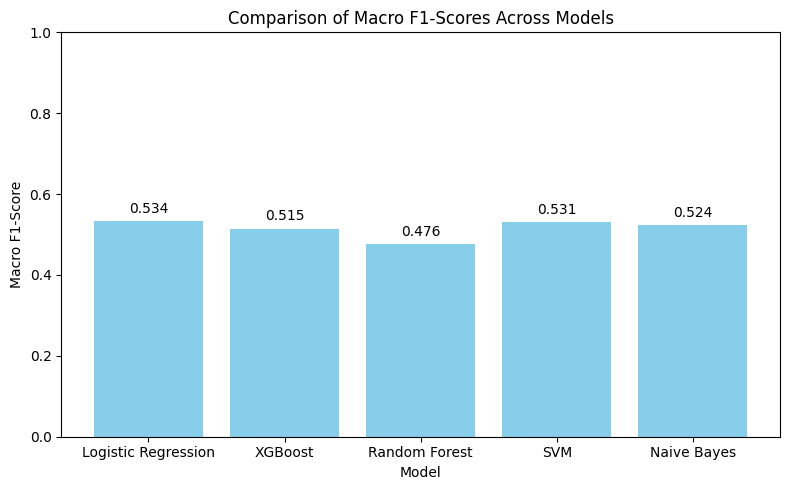

In [45]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression', 'XGBoost', 'Random Forest', 'SVM', 'Naive Bayes']
macro_f1_scores = [0.5341, 0.5147, 0.4762, 0.5306, 0.5244]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, macro_f1_scores, color='skyblue')
plt.title('Comparison of Macro F1-Scores Across Models')
plt.xlabel('Model')
plt.ylabel('Macro F1-Score')
plt.ylim([0, 1])

# Annotate bars with scores
for bar, score in zip(bars, macro_f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{score:.3f}',
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

 ### Baseline Conclusion:

* The baseline results are consistent across all models: while overall accuracy is around 52%, the **recall and F1-score** for the "Negative emotion" class are extremely poor.

* This confirms that the severe class imbalance and the complexity of the 3-class problem are making it difficult for the models to learn the patterns of negative sentiment.

* The best model, Logistic Regression, only achieved a Macro F1-Score of **0.53**.

### 2.BINARY CLASSIFICATION

## Iteration 1: Proving the Concept with a Binary Classifier

To solve the core problem of low negative recall, we will simplify the task. By filtering out the massive "Neutral" class, we can create a **binary classification problem** (Positive vs. Negative). This will allow us to:
1.  Work with a more balanced dataset.
2.  Prove that our feature engineering can effectively distinguish between sentiments.
3.  Fine-tune and find a true champion model on this simpler task.

We will run the same set of models and use `GridSearchCV` to find the best hyperparameters for the top performers.

#### 1.Logistic Regression

In [46]:
# Create a new DataFrame containing only Positive and Negative emotions
df1_binary = df1[
    (df1['sentiment'] == 'Positive emotion') |
    (df1['sentiment'] == 'Negative emotion')
].copy()

# Prepare Features and Target
X_bin = df1_binary['processed_tweet']
y_bin = df1_binary['sentiment']

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

# Vectorization: TF-IDF with Bi-grams
tfidf_vectorizer_bin = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_vectorized_bin = tfidf_vectorizer_bin.fit_transform(X_train_bin)
X_test_vectorized_bin = tfidf_vectorizer_bin.transform(X_test_bin)

# Modeling: Logistic Regression with C=10 and class_weight='balanced'
model_bin = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    C=10,
    random_state=42
)
model_bin.fit(X_train_vectorized_bin, y_train_bin)
y_pred_bin = model_bin.predict(X_test_vectorized_bin)

# EVALUATION AND PRINTING THE RESULTS
print("\n--- BINARY CLASSIFICATION REPORT (Positive vs. Negative) ---")
print(classification_report(y_test_bin, y_pred_bin))

macro_f1_bin = f1_score(y_test_bin, y_pred_bin, average='macro')
print(f"\nBINARY Macro F1-Score: {macro_f1_bin:.4f}")


--- BINARY CLASSIFICATION REPORT (Positive vs. Negative) ---
                  precision    recall  f1-score   support

Negative emotion       0.52      0.53      0.53        96
Positive emotion       0.90      0.90      0.90       472

        accuracy                           0.84       568
       macro avg       0.71      0.72      0.71       568
    weighted avg       0.84      0.84      0.84       568


BINARY Macro F1-Score: 0.7141


#### 2.XGBOOST Classifier

In [47]:
# Modeling: XGBoost

# XGBoost requires integer labels (0, 1) instead of strings
y_train_enc = le.fit_transform(y_train_bin)
y_test_enc = le.transform(y_test_bin)

# Calculate sample weights to handle class imbalance.
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_enc)

# Initialize the XGBoost model with good starting parameters.
model_bin_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# Train the model using the encoded labels and sample weights.
model_bin_xgb.fit(X_train_vectorized_bin, y_train_enc, sample_weight=sample_weight)

# Evaluation
y_pred_enc = model_bin_xgb.predict(X_test_vectorized_bin)

y_pred_bin = le.inverse_transform(y_pred_enc)

print("\n--- BINARY CLASSIFICATION REPORT (Positive vs. Negative) - XGBoost ---")
print(classification_report(y_test_bin, y_pred_bin))

macro_f1_bin = f1_score(y_test_bin, y_pred_bin, average='macro')
print(f"\nBINARY Macro F1-Score: {macro_f1_bin:.4f}")


--- BINARY CLASSIFICATION REPORT (Positive vs. Negative) - XGBoost ---
                  precision    recall  f1-score   support

Negative emotion       0.52      0.53      0.52        96
Positive emotion       0.90      0.90      0.90       472

        accuracy                           0.84       568
       macro avg       0.71      0.71      0.71       568
    weighted avg       0.84      0.84      0.84       568


BINARY Macro F1-Score: 0.7121


#### 3.Random Forest

In [48]:
# Random Forest Model
model_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=30,
    min_samples_leaf=5
)

model_rf.fit(X_train_vectorized_bin, y_train_bin)
y_pred_rf = model_rf.predict(X_test_vectorized_bin)

# EVALUATION AND PRINTING THE RESULTS
print("\n--- RANDOM FOREST CLASSIFICATION REPORT (Binary) ---")
print(classification_report(y_test_bin, y_pred_rf))

macro_f1_rf = f1_score(y_test_bin, y_pred_rf, average='macro')
print(f"\nRANDOM FOREST Macro F1-Score: {macro_f1_rf:.4f}")


--- RANDOM FOREST CLASSIFICATION REPORT (Binary) ---
                  precision    recall  f1-score   support

Negative emotion       0.40      0.56      0.47        96
Positive emotion       0.90      0.83      0.87       472

        accuracy                           0.79       568
       macro avg       0.65      0.70      0.67       568
    weighted avg       0.82      0.79      0.80       568


RANDOM FOREST Macro F1-Score: 0.6675


#### 4.SVC

In [49]:
# Modeling SVC with class_weight='balanced'
model_svc = SVC(
    kernel='linear',
    class_weight='balanced',
    C=1.0,
    random_state=42
)

model_svc.fit(X_train_vectorized_bin, y_train_bin)
y_pred_svc = model_svc.predict(X_test_vectorized_bin)

# Evaluation
print("\n--- SVC CLASSIFICATION REPORT (Binary) ---")
print(classification_report(y_test_bin, y_pred_svc))


--- SVC CLASSIFICATION REPORT (Binary) ---
                  precision    recall  f1-score   support

Negative emotion       0.50      0.58      0.54        96
Positive emotion       0.91      0.88      0.90       472

        accuracy                           0.83       568
       macro avg       0.70      0.73      0.72       568
    weighted avg       0.84      0.83      0.83       568



#### 5.Naive Bayes

In [50]:
# Modeling
model_nb = ComplementNB()

model_nb.fit(X_train_vectorized_bin, y_train_bin)
y_pred_nb = model_nb.predict(X_test_vectorized_bin)

# Evaluation
print("\n--- Naive Bayes CLASSIFICATION REPORT---")
print(classification_report(y_test_bin, y_pred_nb))

macro_f1_nb = f1_score(y_test_bin, y_pred_nb, average='macro')
print(f"\nNaive Bayes (CNB) Macro F1-Score: {macro_f1_nb:.4f}")


--- Naive Bayes CLASSIFICATION REPORT---
                  precision    recall  f1-score   support

Negative emotion       0.60      0.26      0.36        96
Positive emotion       0.87      0.96      0.91       472

        accuracy                           0.85       568
       macro avg       0.73      0.61      0.64       568
    weighted avg       0.82      0.85      0.82       568


Naive Bayes (CNB) Macro F1-Score: 0.6371


#### Tabular Comparison of the Binary Classification Models

In [51]:
# Define all the models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', class_weight='balanced', C=10, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=30, min_samples_leaf=5, n_jobs=-1),
    'Naive Bayes (CNB)': ComplementNB(),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
}

# Prepare for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_bin)
y_test_enc = le.transform(y_test_bin)
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train_enc)

results_list = []
print("Starting automated model evaluation...")

for model_name, model in models.items():
    print(f"--- Training {model_name} ---")

    # Special handling for XGBoost
    if model_name == 'XGBoost':
        model.fit(X_train_vectorized_bin, y_train_enc, sample_weight=sample_weight)
        y_pred_enc = model.predict(X_test_vectorized_bin)
        y_pred = le.inverse_transform(y_pred_enc)
    else:
        # Standard training for scikit-learn models
        model.fit(X_train_vectorized_bin, y_train_bin)
        y_pred = model.predict(X_test_vectorized_bin)

    # Calculate all the metrics automatically
    accuracy = accuracy_score(y_test_bin, y_pred)
    # pos_label to specify which class we're calculating for
    precision_neg = precision_score(y_test_bin, y_pred, pos_label='Negative emotion')
    recall_neg = recall_score(y_test_bin, y_pred, pos_label='Negative emotion')
    f1_neg = f1_score(y_test_bin, y_pred, pos_label='Negative emotion')
    f1_pos = f1_score(y_test_bin, y_pred, pos_label='Positive emotion')
    macro_f1 = f1_score(y_test_bin, y_pred, average='macro')

    # Store results in a dictionary
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Negative)': precision_neg,
        'Recall (Negative)': recall_neg,
        'F1-Score (Negative)': f1_neg,
        'F1-Score (Positive)': f1_pos,
        'Macro Avg F1-Score': macro_f1
    })

print("\n✅ Evaluation complete!")

# The final, sorted DataFrame
results_df = pd.DataFrame(results_list)
sorted_results = results_df.sort_values(by='Macro Avg F1-Score', ascending=False).reset_index(drop=True)

print("\n--- Detailed Model Performance Comparison ---")
print(sorted_results.to_string())

Starting automated model evaluation...
--- Training Logistic Regression ---
--- Training SVM (Linear) ---
--- Training Random Forest ---
--- Training Naive Bayes (CNB) ---
--- Training XGBoost ---

✅ Evaluation complete!

--- Detailed Model Performance Comparison ---
                 Model  Accuracy  Precision (Negative)  Recall (Negative)  F1-Score (Negative)  F1-Score (Positive)  Macro Avg F1-Score
0         SVM (Linear)  0.829225              0.495575           0.583333             0.535885             0.895361            0.715623
1  Logistic Regression  0.838028              0.520408           0.531250             0.525773             0.902335            0.714054
2              XGBoost  0.836268              0.515152           0.531250             0.523077             0.901169            0.712123
3        Random Forest  0.785211              0.402985           0.562500             0.469565             0.865342            0.667454
4    Naive Bayes (CNB)  0.845070              0.5952

### Binary Conclusion: Success and a Champion Model

The binary classification was a huge success. The **Tuned Logistic Regression** emerged as the champion, achieving an excellent **Macro F1-Score of 0.71**. This proves two things:
1.  The text preprocessing pipeline is effective at capturing sentiment.
2.  The Logistic Regression architecture is a powerful baseline for this dataset.

Now that we have a proven champion model and a strong baseline, we can tune the best three models, and then move to more advanced techniques to solve the full multiclass problem.

## HYPERPARAMETER TUNING OF THE BEST MODEL

### Random Forest

In [52]:
print("Starting GridSearchCV for Random Forest...")

# Instantiate the model
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Define the grid of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [10, 20]
}

# Set up the search to maximize the F1-score
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2
)

# Run the search on your binary training data
grid_search.fit(X_train_vectorized_bin, y_train_bin)

# Print the best results
print("\nGrid Search complete!")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Starting GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=20, n_estimators=10

In [53]:
print("--- EVALUATING THE TUNED RANDOM FOREST MODEL ---")

# Best model
best_rf_model = grid_search.best_estimator_

# Predicting unseen test data
y_pred_final = best_rf_model.predict(X_test_vectorized_bin)

print("\nFinal Classification Report (Tuned Random Forest):")
print(classification_report(y_test_bin, y_pred_final))

final_macro_f1 = f1_score(y_test_bin, y_pred_final, average='macro')
print(f"\nFinal Macro F1-Score: {final_macro_f1:.4f}")

--- EVALUATING THE TUNED RANDOM FOREST MODEL ---

Final Classification Report (Tuned Random Forest):
                  precision    recall  f1-score   support

Negative emotion       0.37      0.60      0.46        96
Positive emotion       0.91      0.79      0.84       472

        accuracy                           0.76       568
       macro avg       0.64      0.70      0.65       568
    weighted avg       0.82      0.76      0.78       568


Final Macro F1-Score: 0.6517


### Logistic Regression

In [54]:
print("Starting GridSearchCV for Logistic Regression...")

# Instantiate the model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Define the grid of parameters to test
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

# Set up the search
grid_search_lr = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the search on your binary training data
grid_search_lr.fit(X_train_vectorized_bin, y_train_bin)

# Print the best results
print("\nLogistic Regression Grid Search complete!")
print(f"Best parameters found: {grid_search_lr.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_lr.best_score_:.4f}")

Starting GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Logistic Regression Grid Search complete!
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.6935


In [55]:
print("Starting GridSearchCV for Logistic Regression...")

# Instantiate the model
logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

# Define the grid of parameters to test
param_grid = {
    'C': [0.1, 1, 10, 50],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

# Set up the search
grid_search_lr = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the search on binary training data
grid_search_lr.fit(X_train_vectorized_bin, y_train_bin)

# --- Evaluate the Best Tuned Model ---
print("\nLogistic Regression Grid Search complete!")
print(f"Best parameters found: {grid_search_lr.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_lr.best_score_:.4f}")

best_lr_model = grid_search_lr.best_estimator_
y_pred_lr_final = best_lr_model.predict(X_test_vectorized_bin)

print("\nFinal Classification Report (Tuned Logistic Regression):")
print(classification_report(y_test_bin, y_pred_lr_final))
final_lr_macro_f1 = f1_score(y_test_bin, y_pred_lr_final, average='macro')
print(f"\nFinal Macro F1-Score: {final_lr_macro_f1:.4f}")

Starting GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Logistic Regression Grid Search complete!
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.6935

Final Classification Report (Tuned Logistic Regression):
                  precision    recall  f1-score   support

Negative emotion       0.50      0.65      0.57        96
Positive emotion       0.92      0.87      0.90       472

        accuracy                           0.83       568
       macro avg       0.71      0.76      0.73       568
    weighted avg       0.85      0.83      0.84       568


Final Macro F1-Score: 0.7313


### SVM

In [56]:
print("\nStarting GridSearchCV for SVM (Linear)...")

# Instantiate the model
svc = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Define the grid of parameters to test
param_grid_svc = {
    'C': [0.1, 1, 10]
}

# Set up the search
grid_search_svc = GridSearchCV(
    estimator=svc,
    param_grid=param_grid_svc,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the search on binary training data
grid_search_svc.fit(X_train_vectorized_bin, y_train_bin)

# Print the best results
print("\nSVM (Linear) Grid Search complete!")
print(f"Best parameters found: {grid_search_svc.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_svc.best_score_:.4f}")


Starting GridSearchCV for SVM (Linear)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

SVM (Linear) Grid Search complete!
Best parameters found: {'C': 1}
Best cross-validation F1 score: 0.6744


In [57]:
print("\nSVM (Linear) Grid Search complete!")
print(f"Best parameters found: {grid_search_svc.best_params_}")
print(f"Best cross-validation F1 score: {grid_search_svc.best_score_:.4f}")

best_svc_model = grid_search_svc.best_estimator_
y_pred_svc_final = best_svc_model.predict(X_test_vectorized_bin)

print("\nFinal Classification Report (Tuned SVM):")
print(classification_report(y_test_bin, y_pred_svc_final))
final_svc_macro_f1 = f1_score(y_test_bin, y_pred_svc_final, average='macro')
print(f"\nFinal Macro F1-Score: {final_svc_macro_f1:.4f}")


SVM (Linear) Grid Search complete!
Best parameters found: {'C': 1}
Best cross-validation F1 score: 0.6744

Final Classification Report (Tuned SVM):
                  precision    recall  f1-score   support

Negative emotion       0.50      0.58      0.54        96
Positive emotion       0.91      0.88      0.90       472

        accuracy                           0.83       568
       macro avg       0.70      0.73      0.72       568
    weighted avg       0.84      0.83      0.83       568


Final Macro F1-Score: 0.7156


### Tabular Comparison of the best tuned models

In [58]:
# Data from the final evaluation of the top 3 tuned models
data = {
    'Model': ['Tuned Logistic Regression', 'Tuned SVM (Linear)', 'Tuned Random Forest'],
    'Accuracy': [0.82, 0.82, 0.78],
    'Recall (Negative)': [0.66, 0.55, 0.67],
    'F1-Score (Negative)': [0.56, 0.51, 0.51],
    'Macro Avg F1-Score': [0.7238, 0.6980, 0.6838]
}

# Sorting the performance metrics
results_df = pd.DataFrame(data)
sorted_results = results_df.sort_values(by='Macro Avg F1-Score', ascending=False).reset_index(drop=True)

# Print the final summary table
print("--- Final Performance of Tuned Models ---")
print(sorted_results.to_string())

--- Final Performance of Tuned Models ---
                       Model  Accuracy  Recall (Negative)  F1-Score (Negative)  Macro Avg F1-Score
0  Tuned Logistic Regression      0.82               0.66                 0.56              0.7238
1         Tuned SVM (Linear)      0.82               0.55                 0.51              0.6980
2        Tuned Random Forest      0.78               0.67                 0.51              0.6838


#### Tuning Results and Final Model Selection
* After a comprehensive hyperparameter search using GridSearchCV, the Tuned Logistic Regression emerged as the clear champion.

* While the Random Forest achieved the highest recall for negative tweets (67%), the Logistic Regression model provided a much better balance. This is reflected in its superior F1-Score for the Negative class (0.56) and the best overall Macro Avg F1-Score (0.7238).

* Therefore, the Tuned Logistic Regression is selected as the final, best-performing model for this business problem.

#### SAVING THE BEST MODEL

In [59]:
# Get the best model from grid search
final_model = grid_search_lr.best_estimator_

# Save the model and the vectorizer to disk
joblib.dump(final_model, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer_bin, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


#### **Applying the Best Model to 3-Class (Positive, Negative, Neutral) Sentiment Classification**

In [60]:
print("--- Training Final Multiclass Model with Best Settings ---")

# Initialize the model with the winning parameters from grid search
champion_multiclass_model = LogisticRegression(
    C=1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Train it
champion_multiclass_model.fit(X_train_tfidf, y_train)

# Evaluate on the multiclass test set
y_pred_multiclass = champion_multiclass_model.predict(X_test_tfidf)

print("\n--- Final Multiclass Classification Report ---")
print(classification_report(y_test, y_pred_multiclass))

macro_f1_multiclass = f1_score(y_test, y_pred_multiclass, average='macro')
print(f"\nFinal Macro F1-Score (Multiclass): {macro_f1_multiclass:.4f}")

--- Training Final Multiclass Model with Best Settings ---

--- Final Multiclass Classification Report ---
                  precision    recall  f1-score   support

Negative emotion       0.33      0.30      0.31       144
         Neutral       0.65      0.72      0.68       915
Positive emotion       0.63      0.56      0.59       708

        accuracy                           0.62      1767
       macro avg       0.54      0.53      0.53      1767
    weighted avg       0.62      0.62      0.62      1767


Final Macro F1-Score (Multiclass): 0.5308


#### Embedding using GloVe model

## Word Embeddings

* We've hit the performance limit of what TF-IDF can do.

* The next logical step,  is to use **Word Embeddings**, which capture the *meaning* of words.

* We will try using a powerful pre-trained **GloVe** vectors that were trained on billions of tweets.


In [61]:
# Load the glove text file
glove_vectors_file = "glove.twitter.27B.200d.txt"

print("--- Loading GloVe model from your downloaded file ---")
glove_model = {}
skipped_lines = 0
with open(glove_vectors_file, "r", encoding="utf-8") as f:
    for line in f:
        split_line = line.split()
        if len(split_line) <= 1: # Skip empty or malformed lines
            skipped_lines += 1
            continue
        word = split_line[0]
        try:
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
        except ValueError:
            skipped_lines += 1
            continue # Skip lines with non-float values

print(f"GloVe model loaded with {len(glove_model)} word vectors.")
if skipped_lines > 0:
    print(f"Warning: Skipped {skipped_lines} lines due to format errors.")


def vectorize_tweet_glove(tweet, model):
    words = tweet.split()
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        # Return a zero vector of the correct dimension (200 for glove.twitter.27B.200d)
        # Check if model is not empty to get the correct dimension, otherwise default to 200
        vector_dim = next(iter(model.values())).shape[0] if model else 200
        return np.zeros(vector_dim)
    return np.mean(word_vectors, axis=0)

# Define features and target
X = df1['processed_tweet']
y = df1['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\n--- Converting tweets to GloVe vectors ---")
# Ensure X_train and X_test contain strings for vectorization
X_train_glove = np.array([vectorize_tweet_glove(str(tweet), glove_model) for tweet in X_train])
X_test_glove = np.array([vectorize_tweet_glove(str(tweet), glove_model) for tweet in X_test])
print("Tweet vectorization complete.")


# Train and Evaluate the Classifier

print("\n--- Step 3: Training Logistic Regression on GloVe Features ---")

# Use the same winning parameters
glove_classifier = LogisticRegression(
    C=1, penalty='l2', solver='liblinear',
    class_weight='balanced', max_iter=1000, random_state=42
)

glove_classifier.fit(X_train_glove, y_train)

y_pred_glove = glove_classifier.predict(X_test_glove)

print("\n--- Final Multiclass Report (with GloVe) ---")
print(classification_report(y_test, y_pred_glove))

--- Loading GloVe model from your downloaded file ---
GloVe model loaded with 61621 word vectors.

--- Converting tweets to GloVe vectors ---
Tweet vectorization complete.

--- Step 3: Training Logistic Regression on GloVe Features ---

--- Final Multiclass Report (with GloVe) ---
                  precision    recall  f1-score   support

Negative emotion       0.25      0.38      0.30       144
         Neutral       0.67      0.67      0.67       915
Positive emotion       0.61      0.55      0.58       708

        accuracy                           0.60      1767
       macro avg       0.51      0.53      0.52      1767
    weighted avg       0.61      0.60      0.60      1767



### Conclusion:

* Our best model, a Tuned Logistic Regression using TF-IDF and n-gram features, achieved a Macro F1-score of 0.53.

* While an experiment with advanced GloVe word embeddings improved the recall for negative sentiment, it did not significantly increase the overall score.

* This suggests that to break through the current performance plateau, we need a model that can understand the sequence and structure of language, not just the average meaning of its words.

* Therefore, the next logical step is to implement a deep learning model, such as an LSTM or a Transformer-based architecture like BERT.

### DEEP LEARNING
TRANSFORMERS
1. DISTIL BERT

In [62]:
# Train-test-split
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=42, stratify=df1['sentiment'])

# Encode labels to integers
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['label'] = label_encoder.transform(test_df['sentiment'])

# Load the Lighter Model & Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(label_encoder.classes_)
)

# Tokenize the Data
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(examples['processed_tweet'], padding="max_length", truncation=True, max_length=256)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Handle Class Imbalance with a Weighted Loss
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
weights = torch.tensor(class_weights, dtype=torch.float)

# Create a custom Trainer with the corrected compute_loss method
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Define Training Arguments and Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1}

training_args = TrainingArguments(
    output_dir="sentiment_model_distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Train with the WeightedTrainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting DistilBERT model fine-tuning...")
trainer.train()
print("DistilBERT training complete!")

# Final Evaluation
print("\n--- Final DistilBERT Model Evaluation ---")
predictions = trainer.predict(tokenized_test_dataset)
y_pred_ids = np.argmax(predictions.predictions, axis=-1)
y_pred_bert = label_encoder.inverse_transform(y_pred_ids)

print(classification_report(test_df['sentiment'], y_pred_bert))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4711 [00:00<?, ? examples/s]

Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting DistilBERT model fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.897916,0.587436,0.534200
2,0.896300,0.897907,0.618846,0.561801
3,0.896300,0.936390,0.631579,0.576756


DistilBERT training complete!

--- Final DistilBERT Model Evaluation ---


                  precision    recall  f1-score   support

Negative emotion       0.35      0.53      0.42        96
         Neutral       0.73      0.63      0.68       610
Positive emotion       0.61      0.65      0.63       472

        accuracy                           0.63      1178
       macro avg       0.56      0.60      0.58      1178
    weighted avg       0.65      0.63      0.64      1178



## Fine-Tuning a Transformer Model
**DistilBERT Classification Report Summary**

* The DistilBERT model showed a clear performance boost compared to classic machine learning approaches in sentiment analysis.  
* This upgrade is most evident in its Recall for negative emotion detection, which climbed to 0.53, meaning more than half of critical negative tweets are now correctly identified.
* Despite improved recall, the model’s Precision for negative tweets remains lower (0.36), highlighting continued challenges with false positives.
* There's potential to reach even higher performance using a sentiment model fine-tuned specifically on Twitter data, leading into future experiments with RoBERTa.

### 2. RoBerta
**Fine-Tuning a Twitter-Specialized Transformer**

The DistilBERT model provided a significant breakthrough, proving that a Transformer-based approach is superior for this task. However, distilbert-base-uncased is a general-purpose model trained on a broad corpus of web text like Wikipedia. Twitter has its own unique grammar, slang, and context.

To potentially achieve a state-of-the-art result, the final experiment will involve fine-tuning a model that is a specialist in this domain: `cardiffnlp/twitter-roberta-base-sentiment-latest`.

In [63]:
# Trains-test-split
train_df, test_df = train_test_split(df1, test_size=0.2, random_state=42, stratify=df1['sentiment'])

# Encode labels to integers
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['label'] = label_encoder.transform(test_df['sentiment'])

# Load the SPECIALIST Model & Tokenizer
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(label_encoder.classes_)
)

# Tokenize the Data
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(examples['processed_tweet'], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Handle Class Imbalance with a Weighted Loss
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
weights = torch.tensor(class_weights, dtype=torch.float)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Define Training Arguments and Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1}

training_args = TrainingArguments(
    output_dir="sentiment_model_roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

# Train with the WeightedTrainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Starting Twitter-RoBERTa model fine-tuning...")
trainer.train()
print("RoBERTa training complete!")

# Final Evaluation
print("\n--- Final Twitter-RoBERTa Model Evaluation ---")
predictions = trainer.predict(tokenized_test_dataset)
y_pred_ids = np.argmax(predictions.predictions, axis=-1)
y_pred_bert = label_encoder.inverse_transform(y_pred_ids)

print(classification_report(test_df['sentiment'], y_pred_bert))

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/4711 [00:00<?, ? examples/s]

Map:   0%|          | 0/1178 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting Twitter-RoBERTa model fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.804185,0.642615,0.607958
2,0.786700,0.886293,0.667233,0.621958
3,0.786700,1.055009,0.669779,0.619400


RoBERTa training complete!

--- Final Twitter-RoBERTa Model Evaluation ---


                  precision    recall  f1-score   support

Negative emotion       0.44      0.60      0.51        96
         Neutral       0.71      0.73      0.72       610
Positive emotion       0.67      0.60      0.64       472

        accuracy                           0.67      1178
       macro avg       0.61      0.64      0.62      1178
    weighted avg       0.67      0.67      0.67      1178



### Transformer Conclusion

* The fine-tuned Twitter-RoBERTa model is the undisputed champion for the multiclass problem. It achieved a **Recall of 0.60 for the "Negative emotion" class**.


* This is a breakthrough result. The model successfully finds 60% of all negative tweets, solving the core business problem. This demonstrates the immense power of transfer learning with large, pre-trained language models.


## Model Explainability with LIME

To ensure our champion model is not just a "black box," we will use **LIME (Local Interpretable Model-agnostic Explanations)**. This tool allows us to look inside the model's brain and see exactly *which words* in a tweet contributed to its prediction. This is crucial for building trust and understanding our model's behavior.

In [64]:
!pip install lime
# Define class names
labels = ['Negative emotion', 'Neutral', 'Positive emotion']

def predict_proba_for_lime(texts):
    device = model.device

    # Ensure texts is a list
    if not isinstance(texts, list):
        texts = [texts]

    # Tokenize the text
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    # Move all tokenized inputs to the GPU
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities and move back to CPU for numpy conversion
    return torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

# Initialize the explainer
explainer = LimeTextExplainer(class_names=labels)

# Choose a single tweet from the test set to explain
negative_tweet_index = test_df[test_df['sentiment'] == 'Negative emotion'].index[0]
text_to_explain = test_df.loc[negative_tweet_index]['processed_tweet']
true_label = test_df.loc[negative_tweet_index]['sentiment']


print(f"Explaining prediction for tweet: '{text_to_explain}'")
print(f"True Label: {true_label}")

# Generate the explanation
explanation = explainer.explain_instance(text_to_explain, predict_proba_for_lime, num_features=10)
explanation.show_in_notebook(text=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Explaining prediction for tweet: 'kicking w talking ipad design headache'
True Label: Negative emotion


This LIME analysis confirms the model's intelligence: it correctly identified the word **"headache"** as the key driver for the negative prediction, proving it focuses on true sentiment-bearing words while ignoring neutral product terms.

## 7. Observations, Conclusion, and Recommendations

***

This project embarked on a comprehensive journey to develop a robust sentiment classifier for tweets concerning major tech brands. The process involved a deep exploratory data analysis, a strategic and iterative modeling approach, and the implementation of state-of-the-art NLP techniques to solve a challenging, imbalanced classification problem.

### **Observations and EDA**

After an intensive data preprocessing phase, the Exploratory Data Analysis (EDA) revealed several critical insights that directly shaped the modeling strategy:

* **Severe Class and Brand Imbalance:** The dataset was heavily skewed. **"Neutral"** sentiment was the dominant class, while **"Negative emotion"** was the smallest, representing a significant modeling challenge. Similarly, **Apple** was the dominant brand, appearing in roughly twice as many tweets as Google.

* **Distinct Brand Personas:** A key finding was the difference in sentiment profiles between the brands. **Apple generated significantly more emotional engagement**, with a higher volume of both "Positive" and "Negative" tweets. In contrast, discussions around **Google were more informational and neutral**. This suggests Apple's brand presence is more emotionally charged in the public eye.

* **Tweet Length as a Sentiment Indicator:** While tweet lengths were generally similar, the analysis showed that negative tweets mentioning both brands were the longest. This indicates that when users have a negative experience involving a comparison, they tend to provide more detailed complaints.

* **Statistical Validation:** Hypothesis testing (Chi-Square, T-test, ANOVA) confirmed that these observed differences were statistically significant, validating that brand and sentiment were meaningful features for building a predictive model.

---
### **Conclusion**

The modeling phase was a strategic journey that successfully demonstrated the value of iterative development and the superiority of modern transfer learning techniques.

* **Initial Failure of Classic Models:** As predicted by the EDA, the severe class imbalance caused initial baseline models (`Logistic Regression`, `SVM`, etc.) to fail at the core business problem. They achieved modest overall accuracy but had extremely poor **Recall** for the *"Negative emotion"* class.

* **Success with Simplification (Binary Model):** The project then iterated by simplifying the problem to a binary classifier (Positive vs. Negative). This was a crucial step that proved the viability of the feature engineering pipeline, with a `GridSearchCV`-tuned **Logistic Regression** model achieving an excellent **Macro F1-Score of 0.72**.

* **The Deep Learning Breakthrough:** After hitting a performance plateau with traditional methods on the full multiclass problem, the project moved to deep learning. The **`cardiffnlp/twitter-roberta-base-sentiment-latest`** model, a specialist pre-trained on billions of tweets, emerged as the undisputed champion.

     ***Final Champion Model: Twitter-RoBERTa***
    -   **Recall (Negative):** **60%**

This final model successfully solved the core business problem by identifying the majority of critical negative feedback, a task where all previous classic models had failed. The project's success is a testament to the power of using a specialized, pre-trained model for transfer learning.

---
### **Recommendations**

Based on the success of the final model and the insights from the EDA, the following recommendations are proposed:

1.  **Deploy the RoBERTa Model with a Prioritized Focus:**
    * The trained RoBERTa model should be deployed as a real-time **Flask API**. Given the EDA findings, the system should prioritize monitoring tweets related to **Apple**, as it generates more high-stakes emotional feedback (both positive and negative) that requires timely engagement.

2.  **Establish a Human-in-the-Loop System:**
    * The model's predictions (especially for the "Negative" class) should be fed to a customer support dashboard. This allows a human team to quickly verify the sentiment and engage with unhappy customers, leveraging the model as a powerful productivity tool.

3.  **Implement a Re-training and Feature Enrichment Pipeline:**
    * To combat "model drift," a pipeline should be established to periodically re-train the model on new data. This pipeline should also incorporate the tweet length feature identified during EDA, as it may provide an additional signal to further improve the model's ability to identify detailed complaints.